# Task 2

The second task is about classifying handwritten digits. We will use the MNIST dataset for training and testing. The point of this task is to develop a multi-layer neural network for classification using mostly Numpy:
* Implement sigmoid and relu layers (with forward and backward pass) 
* Implement a softmax output layer 
* Implement a fully parameterizable neural network (number and types of layers, number  of units) 
* Implement an optimizer (e.g. SGD or Adam) and a stopping criterion of your choosing 
* Train your Neural Network using backpropagation.

Evaluate different neural network architectures and compare your different results. You can also compare with the results presented in http://yann.lecun.com/exdb/mnist/


### Loading the Data Set

We will use Pytorch's torchvision module to load the MNIST dataset.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import util

In [2]:
# Downloading MNIST
# Resources used:
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
# https://pytorch.org/docs/stable/torchvision/datasets.html#mnist

transform = transforms.Compose(
    [transforms.ToTensor()])

#Transet is the entire train set... each item is a 2-tuple, containing an tensor (numeric rep of image) and the target value (int)
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)


Size of Train set is 60000
Size of Test set is 10000

Image depicts the target: 5


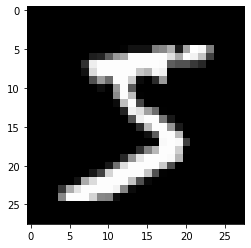

In [3]:
def display_image(image_pos=0, set=trainset):
    # First image's tensor accessed by set[0][0], its shape is 1, 28, 28
    # Notice set[0][1] is the target class of that image.. in this case, 5
    print(f"Image depicts the target: {set[image_pos][1]}")
    # imshow(imshow(torchvision.utils.make_grid(trainset[0][0])))
    imgplot = plt.imshow(set[image_pos][0].numpy().reshape((28, 28)), cmap='gray')


print(f"\nSize of Train set is {len(trainset)}")
print(f"Size of Test set is {len(testset)}\n")

display_image(image_pos=0, set=trainset)


## The Neural Network

In [23]:
class Layer():
    def __init__(self, nodes_of_prev, nodes=784, activation="sigmoid"):
        self.nodes = nodes
        self.activation = activation
        self.nodes_of_prev = nodes_of_prev
        #Additionally, each layer has:
        # - the weights going into it (nodes x nodes_of_prev)
        # - z matrix, the dot product between the previous layer and the weights of this layer (nodes x 1)
        # - a matrix, the result of passing z into the activation function (nodes x 1)
        # - d matrix (nodes x 1)
        self.weights = np.random.rand(self.nodes, self.nodes_of_prev)
        self.z = np.random.rand(self.nodes, 1)
        self.a = np.random.rand(self.nodes, 1)
        self.d = np.zeros(self.a.shape)
    
    def activate(self):
        if(self.activation == "sigmoid"):
            self.a = self.sigmoid(X=self.z)
        if(self.activation == "relu"):
            self.a = self.relu(X=self.z)
        if(self.activation == "softmax"):
            self.a = self.softmax(X=self.z)
            self.a = self.a.reshape(self.nodes, 1)
    
    def derive(self, X):
        if(self.activation == "sigmoid"):
            return (self.sigmoid(X=X, diff=True)).reshape(X.shape)
        if(self.activation == "relu"):
            return (self.relu(X=X, diff=True)).reshape(X.shape)
        if(self.activation == "softmax"):
            return (self.softmax(X=X, diff=True)).reshape(X.shape)
    
    def sigmoid(self, X, diff=False):
        sigmoid_original = 1 / (1 + np.e**(-X))
        if (not diff):
            return sigmoid_original
        else:
            return sigmoid_original * (1 - sigmoid_original)
    
    def relu(self, X, diff=False):
        if(not diff):
            for i in range(len(X)):
                if X[i] <= 0:
                    X[i] = 0
            return X       
        else:
            for i in range(len(X)):
                if X[i] > 0:
                    X[i] = 1
                else:
                    X[i] = 0
            return X

    def softmax(self, X, diff=False):
        if (not diff):
            return (np.e ** X) / sum(np.e ** X)
        else:
            return (np.e ** X) / sum((np.e ** X)) * (1 - (np.e ** X) / np.sum((np.e ** X)))


In [85]:
class NN():
    def __init__(self, X, y, n, lr=0.001):
        self.X = X
        self.y = y
        self.n = n #Number of features
        self.m = len(X) #Number of data points
        self.layers = []
        self.loss_history = []
        self.a0 = None
        self.hx = None
        self.lr = lr
    
    def add_layer(self, nodes=784, activation="sigmoid"):
        number_of_layers = len(self.layers)
        #If the layers array is empty, the layer to be added will have its nodes_of_prev equal n
        if number_of_layers == 0:
            layer_to_add = Layer(nodes_of_prev=len(self.X[0]), nodes=nodes, activation=activation)
            self.layers.append(layer_to_add)
        #Else, the layer to be added will have its nodes_of_prev equal the nodes of the previous layer in self.layers
        else:
            prev_layer = self.layers[number_of_layers - 1]
            layer_to_add = Layer(nodes_of_prev=prev_layer.nodes, nodes=nodes, activation=activation)
            self.layers.append(layer_to_add)
    
    def forward_pass(self, X):
        for i in range(len(self.layers)):
            layer = self.layers[i]
            # print(f"Forward, to layer {i}!")
            if i == 0:
                self.a0 = X
                layer.z = layer.weights.dot(self.a0)
                layer.activate()
            else:
                prev_layer = self.layers[i - 1]
                layer.z = layer.weights.dot(prev_layer.a)
                layer.activate()
                if i == (len(self.layers) - 1):
                    self.hx = layer.a
    
    def backward_pass(self, X, y):
        y = y.reshape(self.hx.shape)
        last_layer_index = len(self.layers) - 1

        #Calculate All Deltas
        i = last_layer_index
        while i >= 0:
            # print(f"Calculating Deltas of layer {i}")
            layer = self.layers[i]
            #If this is the last layer
            if (i == last_layer_index):
                layer.d = self.hx - y
                # print(f"Layer {i}'s delta, has shape {layer.d.shape}'")
            else:
                next_layer = self.layers[i + 1]
                derived_z = layer.derive(layer.z)
                derived_z = derived_z.reshape(layer.z.shape[0], 1)
                layer.d = next_layer.weights.transpose().dot(next_layer.d) * derived_z
                # print(f"Layer {i}'s delta, has shape {layer.d.shape}'")
            #Decrement
            i -= 1
        
        #Update all Weights
        for i in range(len(self.layers)):
            # print(f"Updating weights of layer {i}")
            layer = self.layers[i]

            if (i == 0):
                self.a0 = X.reshape(self.n, 1)
                layer.weights -= layer.d.dot(self.a0.transpose()) / self.m
            else:
                prev_layer = self.layers[i - 1]
                prev_layer.a = prev_layer.a.reshape(prev_layer.a.shape[0], 1)
                layer.weights -= layer.d.dot(prev_layer.a.transpose()) / self.m

    def fit(self, epochs):
        loss = 0
        for e in range(epochs):
            print(f"Starting epoch {e + 1}/{epochs}")
            for i in range(self.m):
                Xi = self.X[i]
                yi = self.y[i]
                self.forward_pass(Xi)
                print(f"Predicted {util.decode(util.encode_probabilities(self.hx))}")
                self.backward_pass(Xi, yi)
                loss = self.calc_loss(self.hx, yi)
                self.loss_history.append(loss)
                print(f"Loss is {loss}")

    def calc_loss(self, hx, y):
        y = np.array(y)
        loss = (sum(sum((y * np.log(hx)) + ((1 - y) * np.log(1 - hx)))) / self.m) * -1
        return loss
    
    def predict(self, X_test, verbose=0):
        predictions = []
        for x in X_test:
            self.forward_pass(x)
            predictions.append(self.hx)
            if(verbose > 0):
                print(f"the prediction:")
                print(f"{self.hx}")
        return predictions


In [86]:
features, target = util.preprocess(X=trainset.data, y=trainset.targets, m=len(trainset.data), n=len(trainset.data[0])**2)
nn = NN(X=features, y=target, n=784, lr=0.1)
nn.add_layer(nodes=200, activation="relu")
nn.add_layer(nodes=150)
nn.add_layer(nodes=10, activation="softmax")

In [87]:
epochs_to_do = 2
nn.fit(epochs=epochs_to_do)

redicted 7
Loss is 0.0005420561127675999
Predicted 7
Loss is 0.0005420551963659204
Predicted 7
Loss is 0.0005420582300384061
Predicted 7
Loss is 0.0005420627086111007
Predicted 7
Loss is 0.0005420586568659256
Predicted 7
Loss is 0.0005420632362697745
Predicted 7
Loss is 0.0005420663346230767
Predicted 7
Loss is 0.0005420681687526959
Predicted 7
Loss is 0.0005420701106141502
Predicted 7
Loss is 0.0005420732886683855
Predicted 7
Loss is 0.0005420710228705235
Predicted 7
Loss is 0.0005420690047928342
Predicted 7
Loss is 0.0005420736051726
Predicted 7
Loss is 0.0005420726538301199
Predicted 7
Loss is 0.000542074637456574
Predicted 7
Loss is 0.0005420739523732171
Predicted 7
Loss is 0.0005420734481802868
Predicted 7
Loss is 0.0005420693682789806
Predicted 7
Loss is 0.0005420689596766127
Predicted 7
Loss is 0.0005420667127899768
Predicted 7
Loss is 0.0005420660918781198
Predicted 7
Loss is 0.0005420654561074243
Predicted 7
Loss is 0.0005420645247168274
Predicted 7
Loss is 0.00054206398202722

120000


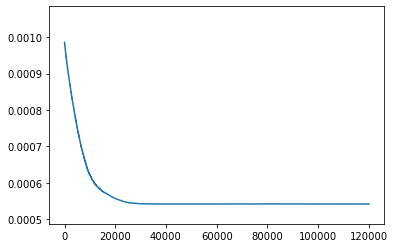

In [88]:
history = nn.loss_history
print(len(history))
plt.ylim((min(history) * 0.9), (max(history)* 1.1))
plt.plot(list(range(epochs_to_do * 60000)), history)
plt.show()

In [89]:
X_test, y_test = util.preprocess(X=testset.data, y=testset.targets, m=len(testset.data), n=len(testset.data[0])**2)
print(X_test.shape)

iteration = 2
print(y_test[iteration])
predictions = nn.predict(X_test)
# predictions_encoded = util.encode_probabilities(prediction)

print(util.encode_probabilities(predictions[iteration]))

(10000, 784)
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]]


In [90]:
for i in range(len(X_test)):
    nn.forward_pass(X_test[100])
    print(util.decode(util.encode_probabilities(nn.hx)))

7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7


In [80]:
# print(X_test[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0  84 185 159 151  60  36   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0 222 254 254 254
 254 241 198 198 198 198 198 198 198 198 170  52   